In [2]:
import MDAnalysis as mda
import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')
from MDAnalysis.analysis import align
import nglview as nv
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Align and average structure
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

# Select a specific segment
u = u.select_atoms ('all')
alpha = u.select_atoms('bynum 1:4368')
ct_alpha = u.select_atoms('bynum 4368:4505')
beta = u.select_atoms('bynum 4506:8801')
ct_beta = u.select_atoms('bynum 8802:9035')
stalk = u.select_atoms('bynum 9036:9808', 'bynum 10732 :11596')
mtbd = u.select_atoms('bynum 9809:10726')
tublin = alpha+beta
ctails = ct_alpha + ct_beta
sys_wo_ct_stalk = u - ctails - stalk
mtbd_stalk = stalk+mtbd

In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12

def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    ax.set_xlim(left=xmin, right=(xmax*1.05))
    ax.set_ylim(bottom=ymin, top=(ymax*1.15))

    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))  # Set major ticks every 1 ns
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))  # Set minor ticks every 0.2 ns
    ax.yaxis.set_major_locator(ticker.AutoLocator())  # Auto set major ticks for y-axis
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())  # Auto set minor ticks for y-axis

    return fig, ax

Average RMSD: 7.123836690889749
RMSD for the Complete system


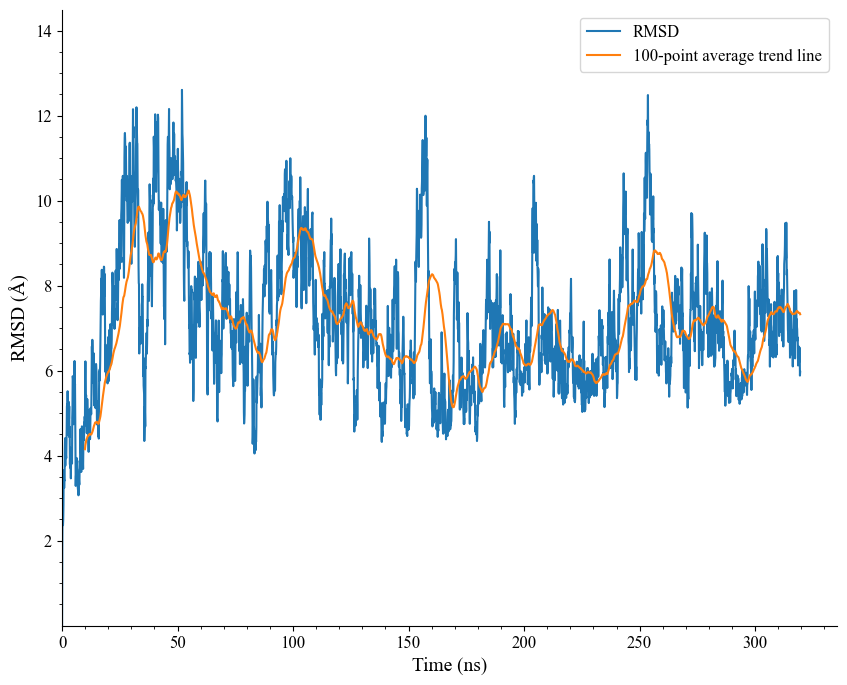

In [51]:
import pandas as pd

# Run the RMSD computation
rmsd = rms.RMSD(u, u).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Calculate the rolling average
window_size = 100  # choose the appropriate window size
rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
rmsd_df['Rolling Avg RMSD'] = rmsd_df['RMSD'].rolling(window_size).mean()

print("RMSD for the Complete system")
# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(rmsd_df['Time'], rmsd_df['Rolling Avg RMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/raw_RMSD_avg.png", dpi=300)
plt.show()



Average RMSD: 3.6966208916578807
RMSD for system without Stalk and CTTs


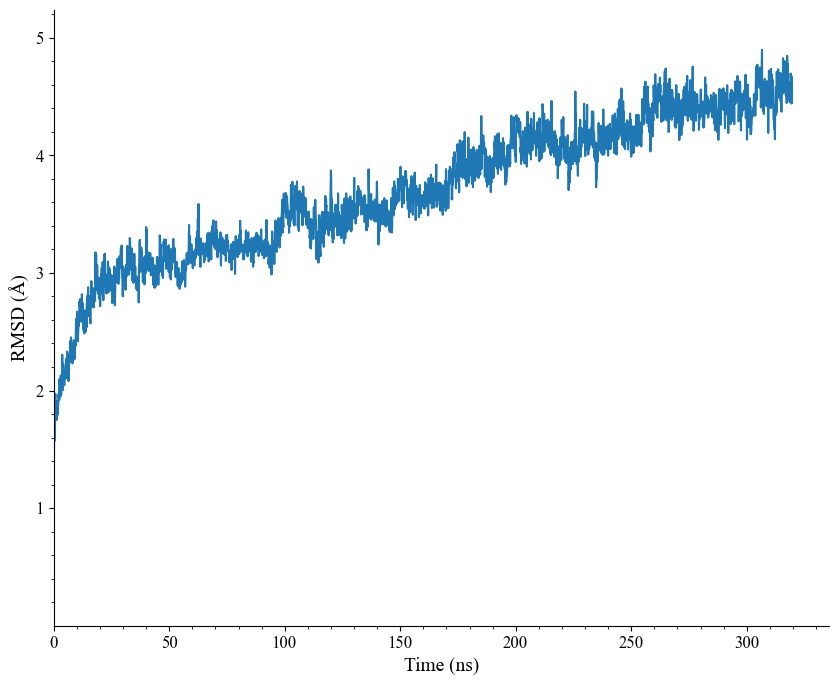

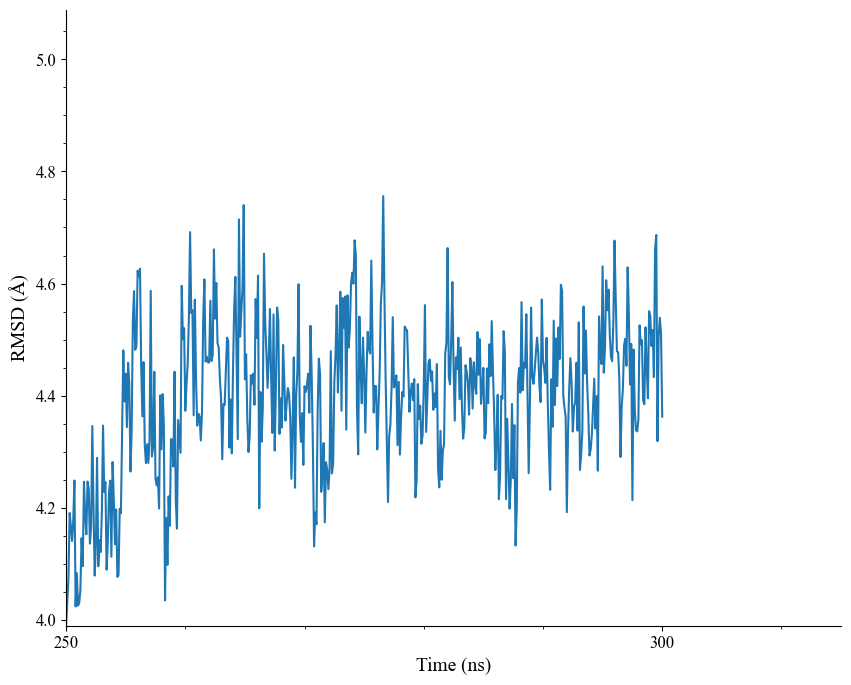

Average RMSD for the first 50 ns: 7.534464695402836
Average RMSD for the last 50 ns: 6.920199318962579


In [39]:
# Compute the RMSD for all atoms in the system
rmsd = rms.RMSD(sys_wo_ct_stalk, sys_wo_ct_stalk).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Filter the time and RMSD values for the specified range
start_time, end_time = 250, 300  # in nanoseconds
mask = np.logical_and(time_ns >= start_time, time_ns <= end_time)

filtered_time_ns = time_ns[mask]
filtered_rmsd_values = rmsd_values[mask]

print("RMSD for system without Stalk and CTTs")
# Plot the RMSD values for all times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values)
plt.savefig("Final Graphs/system_wo_ct_stalk_RMSD.png", dpi=300)
plt.show()

# Plot the RMSD values for the filtered times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(filtered_time_ns), xmax=max(filtered_time_ns), ymin=min(filtered_rmsd_values), ymax=max(filtered_rmsd_values))
ax.plot(filtered_time_ns, filtered_rmsd_values)
plt.savefig("Final Graphs/system_wo_ct_stalk_RMSD_filtered.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 3.6966208916578807
RMSD for system without Stalk and CTTs


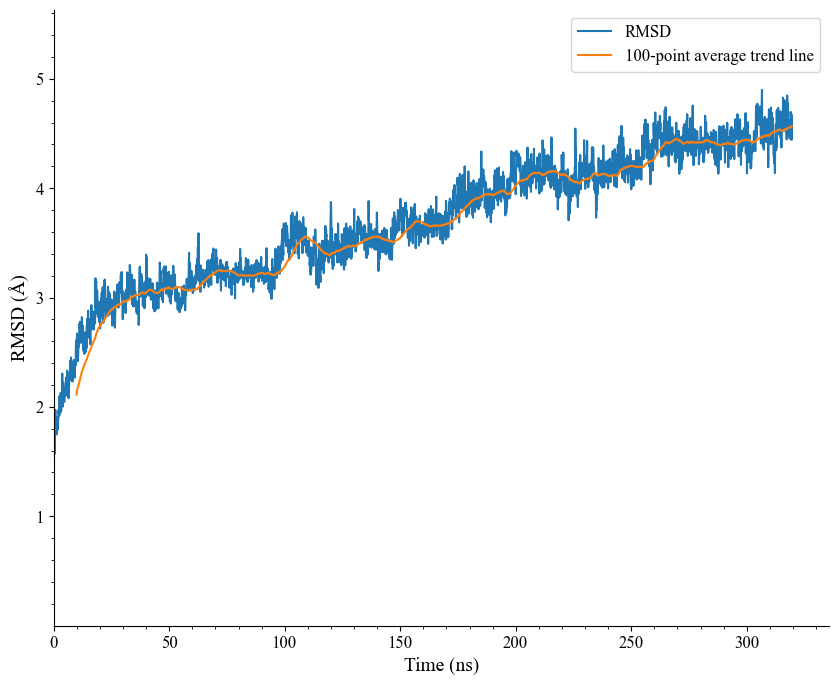

Average RMSD for the first 50 ns: 2.787876560056327
Average RMSD for the last 50 ns: 4.461361599815966


In [52]:
import pandas as pd

# Compute the RMSD for all atoms in the system
rmsd = rms.RMSD(sys_wo_ct_stalk, sys_wo_ct_stalk).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in ns
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Filter the time and RMSD values for the specified range
start_time, end_time = 250, 300  # in nanoseconds
mask = np.logical_and(time_ns >= start_time, time_ns <= end_time)

filtered_time_ns = time_ns[mask]
filtered_rmsd_values = rmsd_values[mask]

print("RMSD for system without Stalk and CTTs")

# Calculate rolling average over a window of N
N = 100  # Define your window size. Adjust this value to your needs.
data = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
data['RollingAvgRMSD'] = data['RMSD'].rolling(window=N).mean()

# Plot the RMSD values for all times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(data['Time'], data['RollingAvgRMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/system_wo_ct_stalk_RMSD_avg.png", dpi=300)
plt.show()

# Create a DataFrame from your data
rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})

# Create masks for the first 50 ns and last 50 ns
first_50_mask = rmsd_df['Time'] <= 50
last_50_mask = rmsd_df['Time'] >= rmsd_df['Time'].max() - 50

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")



Average RMSD: 3.439819215344588
RMSD for tublin


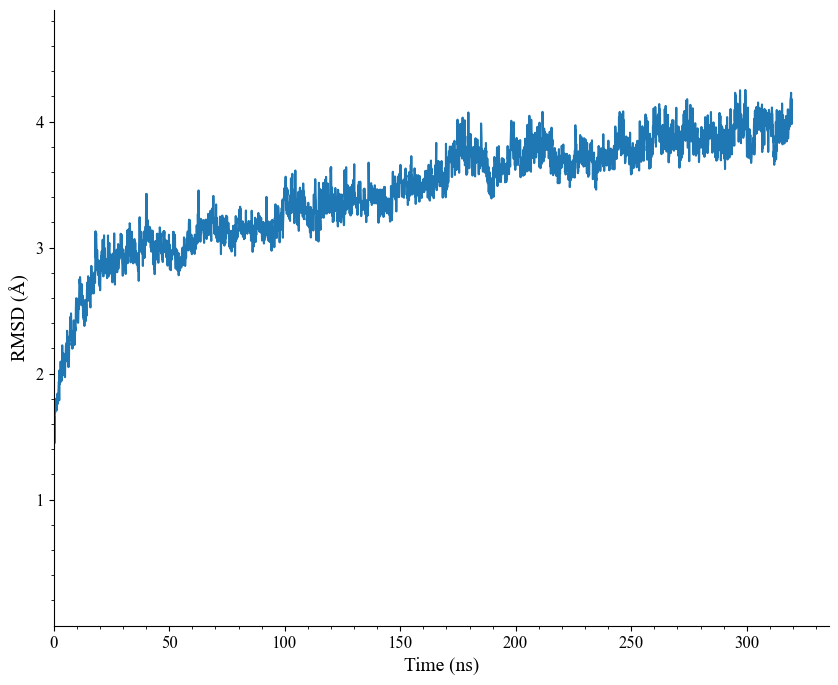

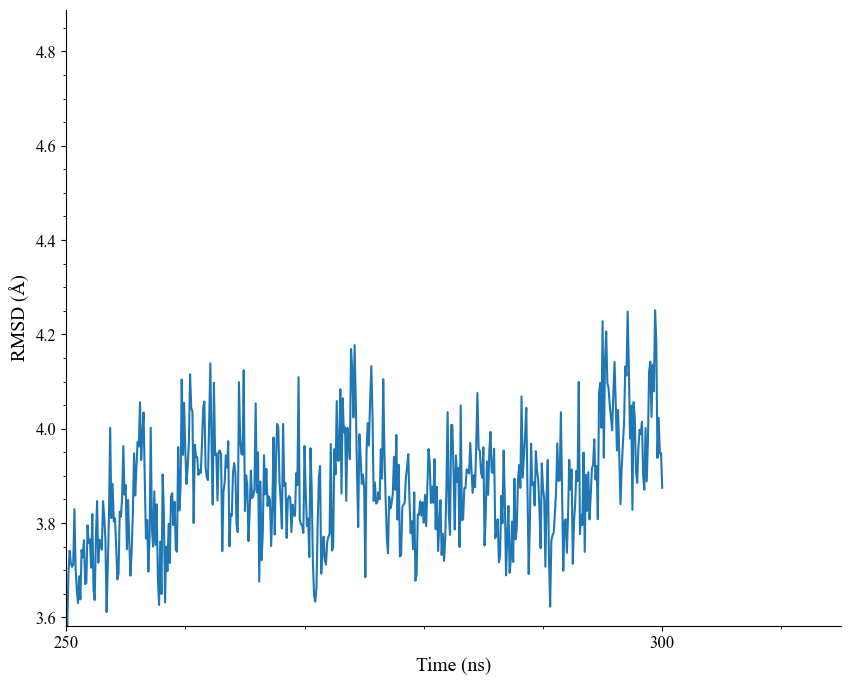

Average RMSD for the first 50 ns: 2.728303913028161
Average RMSD for the last 50 ns: 3.9124971678604448


In [53]:
import pandas as pd
# Compute the RMSD for tublin
rmsd = rms.RMSD(tublin, tublin).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Filter the time and RMSD values for the specified range
start_time, end_time = 250, 300  # in nanoseconds
mask = np.logical_and(time_ns >= start_time, time_ns <= end_time)

filtered_time_ns = time_ns[mask]
filtered_rmsd_values = rmsd_values[mask]

print("RMSD for tublin")
# Plot the RMSD values for all times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values)
plt.savefig("Final Graphs/dimer_RMSD.png", dpi=300)
plt.show()

# Plot the RMSD values for the filtered times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(filtered_time_ns), xmax=max(filtered_time_ns), ymin=min(filtered_rmsd_values), ymax=max(filtered_rmsd_values))
ax.plot(filtered_time_ns, filtered_rmsd_values)
plt.savefig("Final Graphs/dimer_RMSD_filtered.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 3.439819215344588
RMSD for tublin


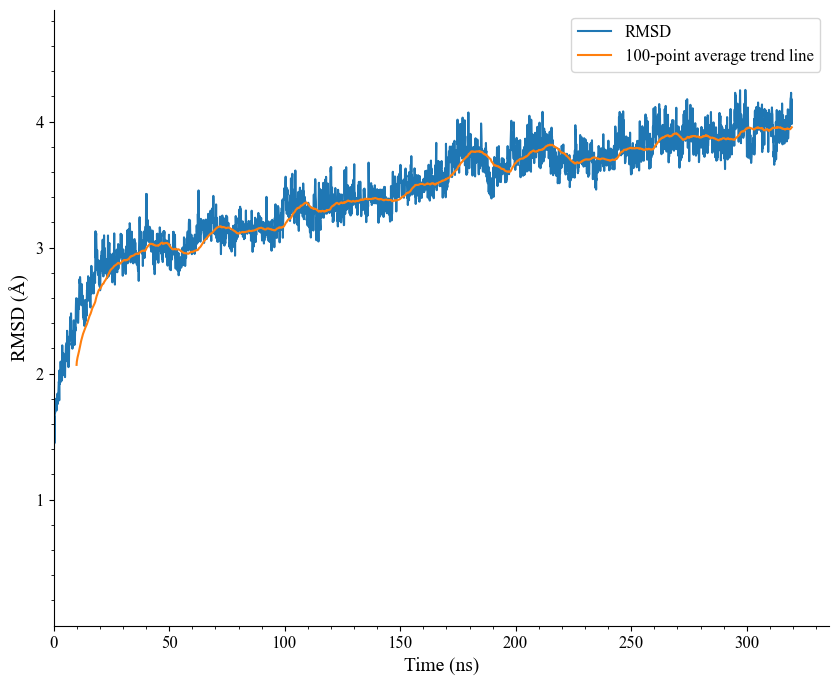

Average RMSD for the first 50 ns: 2.728303913028161
Average RMSD for the last 50 ns: 3.9124971678604448


In [54]:
import pandas as pd 
# Compute the RMSD for tublin
rmsd = rms.RMSD(tublin, tublin).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Filter the time and RMSD values for the specified range
start_time, end_time = 250, 300  # in nanoseconds
mask = np.logical_and(time_ns >= start_time, time_ns <= end_time)

filtered_time_ns = time_ns[mask]
filtered_rmsd_values = rmsd_values[mask]

print("RMSD for tublin")

# Calculate rolling average over a window of N for all times
N = 100  # Define your window size. Adjust this value to your needs.
data_all = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
data_all['RollingAvgRMSD'] = data_all['RMSD'].rolling(window=N).mean()

# Plot the RMSD values for all times
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(data_all['Time'], data_all['RollingAvgRMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/dimer_RMSD_avg.png", dpi=300)
plt.show()

rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 3.4864739771822433
RMSD for alpha


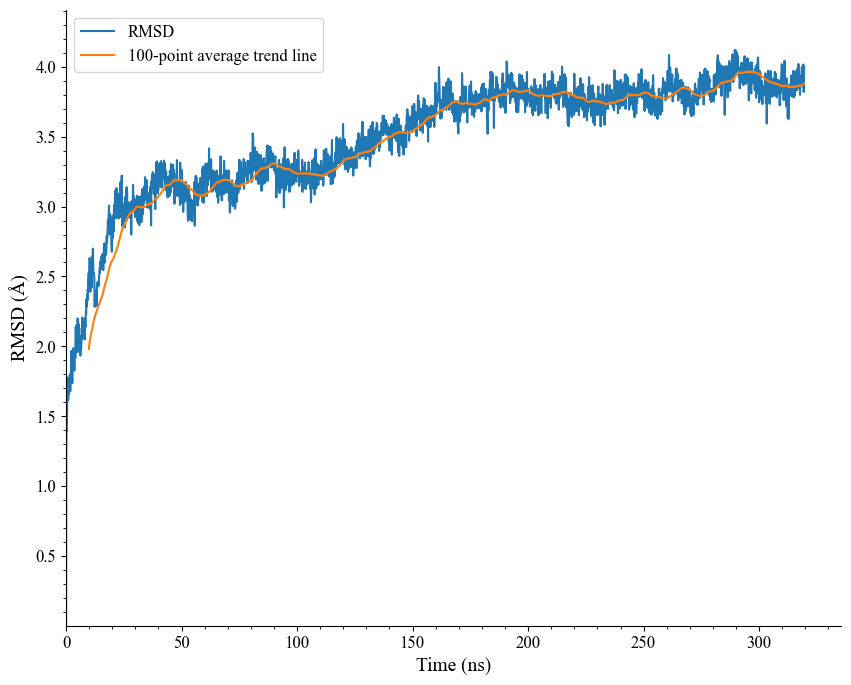

Average RMSD for the first 50 ns: 7.534464695402836
Average RMSD for the last 50 ns: 6.920199318962579


In [43]:
# Compute the RMSD for alpha
rmsd = rms.RMSD(alpha, alpha).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

print("RMSD for alpha")

# Calculate rolling average over a window of N
N = 100  # Define your window size. Adjust this value to your needs.
data_all = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
data_all['RollingAvgRMSD'] = data_all['RMSD'].rolling(window=N).mean()

# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(data_all['Time'], data_all['RollingAvgRMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/Alpha_RMSD_avg.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 2.7389797892247003
RMSD for beta


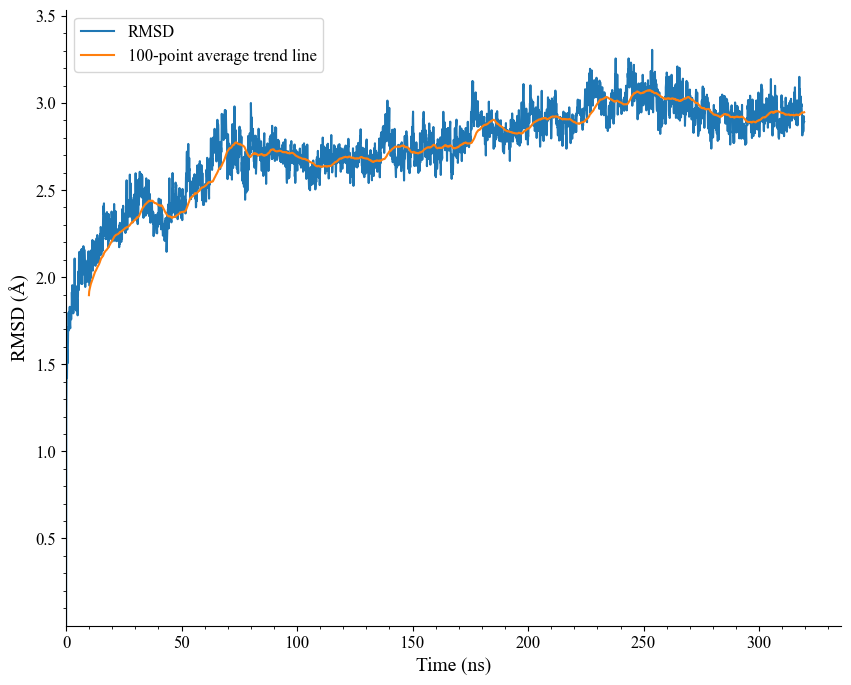

Average RMSD for the first 50 ns: 7.534464695402836
Average RMSD for the last 50 ns: 6.920199318962579


In [44]:
# Compute the RMSD for beta
rmsd = rms.RMSD(beta, beta).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

print("RMSD for beta")

# Calculate rolling average over a window of N
N = 100  # Define your window size. Adjust this value to your needs.
data_all = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
data_all['RollingAvgRMSD'] = data_all['RMSD'].rolling(window=N).mean()

# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(data_all['Time'], data_all['RollingAvgRMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/Beta_RMSD_avg.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 4.415882279600661
RMSD for stalk


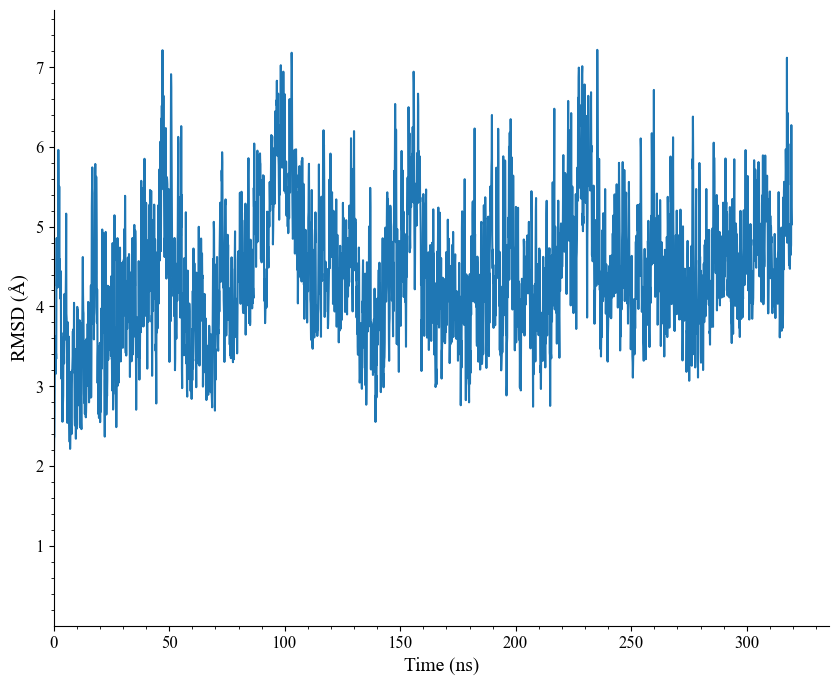

Average RMSD for the first 50 ns: 7.534464695402836
Average RMSD for the last 50 ns: 6.920199318962579


In [45]:
# Compute the RMSD for stalk
rmsd = rms.RMSD(stalk, stalk).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

print("RMSD for stalk")
# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values)
plt.savefig("Final Graphs/stalk_RMSD.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 5.389116473324433
RMSD for ct_alpha


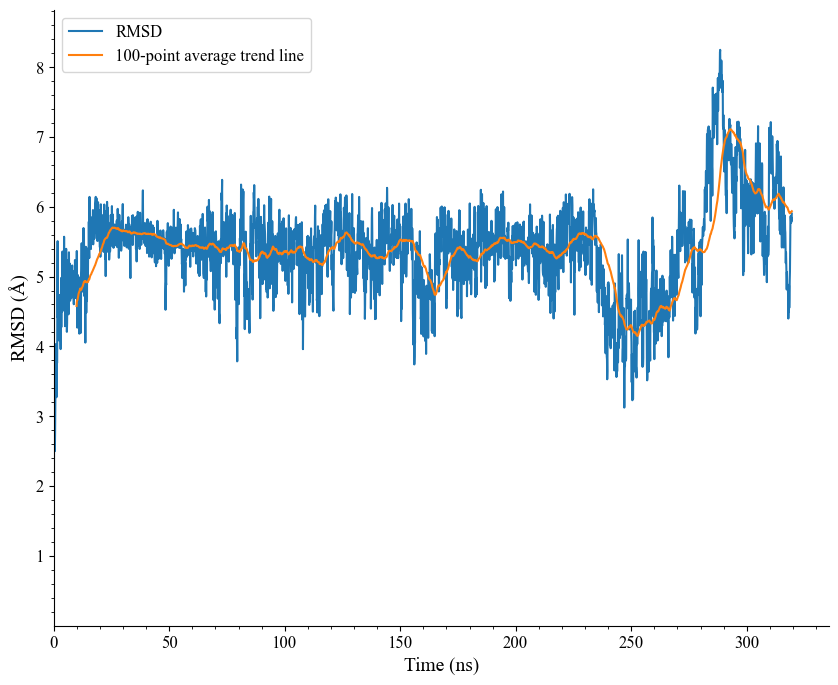

Average RMSD for the first 50 ns: 5.327496596692517
Average RMSD for the last 50 ns: 6.106607843476055


In [46]:
import pandas as pd

# Compute the RMSD for ct_alpha
rmsd = rms.RMSD(ct_alpha, ct_alpha).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Calculate the rolling average
window_size = 100  # choose the appropriate window size
rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
rmsd_df['Rolling Avg RMSD'] = rmsd_df['RMSD'].rolling(window_size).mean()

print("RMSD for ct_alpha")
# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(rmsd_df['Time'], rmsd_df['Rolling Avg RMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/ct_alpha_RMSD_avg.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")


Average RMSD: 7.292131257680547
RMSD for ct_beta


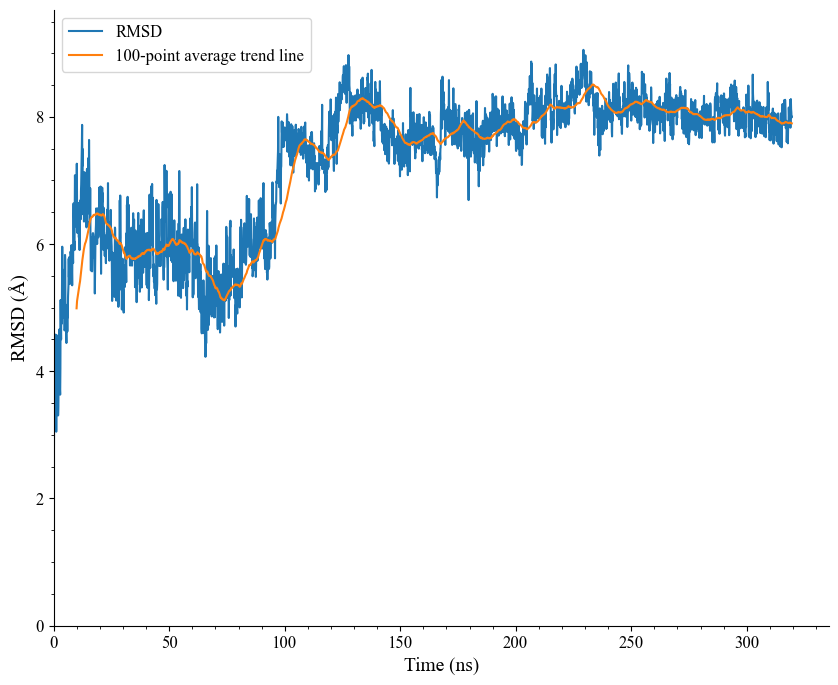

Average RMSD for the first 50 ns: 5.850536437704344
Average RMSD for the last 50 ns: 8.005627505900808


In [47]:
# Compute the RMSD for ct_beta
rmsd = rms.RMSD(ct_beta, ct_beta).run()

# Extract the RMSD values
rmsd_values = rmsd.rmsd.T   # transpose for easier manipulation

time_ps = rmsd_values[1]  # in picoseconds
rmsd_values = rmsd_values[2]

# Compute the average RMSD
average_rmsd = np.mean(rmsd_values)
print(f"Average RMSD: {average_rmsd}")

# Convert time to nanoseconds for plotting
time_ns = time_ps / 1000

# Calculate the rolling average
window_size = 100  # choose the appropriate window size
rmsd_df = pd.DataFrame({'Time': time_ns, 'RMSD': rmsd_values})
rmsd_df['Rolling Avg RMSD'] = rmsd_df['RMSD'].rolling(window_size).mean()

print("RMSD for ct_beta")
# Plot the RMSD values
fig, ax = setup_plot('Time (ns)', 'RMSD (Å)', xmin=min(time_ns), xmax=max(time_ns), ymin=min(rmsd_values), ymax=max(rmsd_values))
ax.plot(time_ns, rmsd_values, label='RMSD')
ax.plot(rmsd_df['Time'], rmsd_df['Rolling Avg RMSD'], label='Rolling Avg RMSD')
ax.legend(labels=['RMSD', '100-point average trend line'])
plt.savefig("Final Graphs/ct_beta_RMSD_avg.png", dpi=300)
plt.show()

# Create a mask for the first 50 ns and last 50 ns
first_50_mask = (time_ns <= 50)
last_50_mask = (time_ns >= time_ns.max() - 50)

# Calculate the average RMSD for these periods
average_rmsd_first_50 = rmsd_df.loc[first_50_mask, 'RMSD'].mean()
average_rmsd_last_50 = rmsd_df.loc[last_50_mask, 'RMSD'].mean()

print(f"Average RMSD for the first 50 ns: {average_rmsd_first_50}")
print(f"Average RMSD for the last 50 ns: {average_rmsd_last_50}")
